<center><h1><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h1></center>

## __Importing Libraries, Classes, and Functions__

In [ ]:
# !pip install torch-xla #Colab

In [2]:
#Standard library
import os
import sys
import json
import time
import shutil
from operator import itemgetter

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report

# Torch
import torch
from torch import jit
import torch.nn as nn  # provides classes/modules for making neural networks
from torch.nn import Linear, Dropout
import torch.nn.functional as F  # a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim  # contains optimization algorithms like SGD
from torchvision import datasets, transforms  # includes MNIST, transform images -> tensors
from torch.utils.data import DataLoader, Subset, ConcatDataset  # allows shuffling and minbatches

#Colab
#import torch_xla
#import torch_xla.core.xla_model as xm  # tpu
#from google.colab import files

In [3]:
current_dir = os.getcwd()

src_dir = os.path.join(current_dir, '..', 'src') #pathtocurrentdir/../src
sys.path.append(src_dir) #adds to list of strings that Python checks to import module; resets everytime you restart kernel

In [4]:
# Local/custom imports
from custom_dataset import DataSetT

## __Initializing the Hyperparameters__

In [ ]:
class Hypers:
    def __init__(self, hyperpath):
        with open(hyperpath, 'r') as file:
            hyper_dict = json.load(file)
        self.l_rate = hyper_dict['learning_rate']
        self.b_size = hyper_dict['batch_size']
        self.epochs = hyper_dict['epochs']
        self.drop_rate = hyper_dict['dropout_rate']
        self.hidden_one = hyper_dict['hidden_one']
        self.hidden_two = hyper_dict['hidden_two']
        self.n_slope = hyper_dict['n_slope']
        self.augment = hyper_dict['augment']
        self.prob_augment = hyper_dict['prob_augment']
        self.beta_one = hyper_dict['beta_one']
        self.beta_two = hyper_dict['beta_two']
        self.degrees = hyper_dict['degrees']
        self.trans_horz = hyper_dict['trans_horz']
        self.trans_vert = hyper_dict['trans_vert']
        self.scale_min = hyper_dict['scale_min']
        self.scale_max = hyper_dict['scale_max']
        self.shear = hyper_dict['shear']
        self.brightness = hyper_dict['brightness']
        self.contrast = hyper_dict['contrast']


#can feed this into functions that need hypers
hypers = Hypers('../config/mlp-hyperparameters.json')

## __Model Architecture__

In [ ]:
class MLP(nn.Module):  #a module
    def __init__(self, hypers, input_dim = 784, output_dim = 10):
        super(MLP, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent (nn.Module) technically initialized too and tied to child but you only access child
        self.fc1 = Linear(in_features = input_dim, out_features = hypers.hidden_one) #num features = num neurons in input layer (1 neuron per feature/vector component); 28^2 pixels
        self.fc2 = Linear(hypers.hidden_one, hypers.hidden_two) #each layer is submodule
        self.fc3 = Linear(hypers.hidden_two, output_dim)
        
        self.n_slope = hypers.n_slope
        self.dropout = Dropout(p = hypers.drop_rate) if hypers.drop_rate > 0 else nn.Identity() #basically no op; TorchScript requires all attributes to be defined
    
    def forward(self, x, input_dim = 784):
        x = x.view(-1, input_dim)  # Flatten the input tensor (batch_size, 1, 28, 28) to (batch_size, 784)

        z1 = self.fc1(x) #Weight matrix + bias vector
        a1 = F.leaky_relu(z1, negative_slope= self.n_slope) 
        a1 = self.dropout(a1) #if dropout>0 apply; identity very fast 

        z2 = self.fc2(a1)
        a2 = F.leaky_relu(z2, negative_slope= self.n_slope) 
        a2 = self.dropout(a2)

        outputs = self.fc3(a2)
        
        return outputs

## __Data Loading and Preparation__

### __Setting up Device__

In [ ]:
#device = xm.xla_device() #Sets up commmunication between CPU and TPU
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

### __Setting the Seed__

In [ ]:
seed = 20
torch.manual_seed(seed)
np.random.seed(seed)

### __Defining the Transformations__

In [1]:
'''Transformation function object applies transformations in list sequentially (e.g. images into tensors 
-> normalize). Normalizing/condensing pixels to 0-1 to make model focuses more on relationships instead
of brightness levels.'''
def transformations(hypers):
    #To tensor scales pixel values from 0 to 1, 
    transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

    if (hypers.augment == True):
        #degrees - max rotation; translation - max horizontal/vert shift, scale - scaling range, shear - up to 10 degrees for both axes
        #all these are hypers
        partial_aug = transforms.RandomAffine(degrees = hypers.degrees, translate = (hypers.trans_horz, hypers.trans_vert), 
                                  scale = (hypers.scale_min, hypers.scale_max), shear = (hypers.shear, hypers.shear))
        
        transform_aug = transforms.Compose([partial_aug, transforms.ColorJitter(brightness = hypers.brightness, contrast = hypers.contrast), 
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,), (0.5,))
                                        ])
        
    else:
        transform_aug = transform_norm
    
    return transform_norm, transform_aug

In [ ]:
transform_norm, transform_aug = transformations(hypers)

### __Loading the Data__

In [ ]:
'''like list of tuples of (image (tensor), label). First element of tuple is 3d array (channels, width, length) for the image. Grayscale
dimension doesn't add new info. Second elemnt of tuple is just an integer for the label. Feature inputs (pixels) commonly denoted
x and outputs (labels) as y.'''
#Used for approach 1 for augmenting and for creating aug_dataset in approach 2
train_dataset = datasets.MNIST(root = '../data', train = True, download = False, transform = None)
norm_dataset = datasets.MNIST(root = '../data', train = True, download = False, transform = transform_norm) #used in approach 2

test_dataset = datasets.MNIST(root = '../data', train = False, download = False, transform = transform_norm) #Download = true on Colab
test_loader = DataLoader(test_dataset, batch_size = 512, shuffle = False, pin_memory=True, num_workers=2) #benchmarks show no workers for evaluation is faster

### __Data Augmentation__

#### __Methods to Get Proper Proportions of Augmented and Original Data__

In [ ]:
def extract(dataset):
    images = []
    labels = []
    for image, label in dataset:
        images.append(image)
        labels.append(label) 
    return images, labels

def _calculate_indices(dataset, hypers):
    len_train = len(dataset)

    num_norm_indices = int(len_train * (1 - hypers.prob_augment))
    num_aug_indices = int(len_train * hypers.prob_augment)

    all_indices = np.random.permutation(len_train) #random array of numbers 0 to n-1

    #part of permutation is indices for norm images, rest is augmented
    norm_indices = all_indices[0:num_norm_indices] 
    aug_indices = all_indices[num_norm_indices:]

    return norm_indices, aug_indices

def create_dataset_t(dataset, indices, transformation):
    subset = Subset(dataset, indices)
    images, labels = extract(subset) #MNIST has .data and .labels apparently so extract not necessary
    return DataSetT(images, labels, transformation)


def norm_aug_loader_one(dataset, hypers):
    norm_indices, aug_indices = _calculate_indices(dataset, hypers)

    #For norm and aug, create a subset of the data, create Data instance so relevant transformation is applied when DataLoader gets image
    norm_dataset = create_dataset_t(dataset, norm_indices, transformation=transform_norm)
    aug_dataset = create_dataset_t(dataset, aug_indices, transform_aug)

   #Concat determines what dataset contains that index -> recalculates index for that dataset -> delegates __getitem__ call to that Data instance
    norm_aug_trainset = ConcatDataset([norm_dataset, aug_dataset])
    return DataLoader(norm_aug_trainset, batch_size = hypers.b_size, shuffle=True, pin_memory=True, num_workers=8, prefetch_factor=8, persistent_workers=True)

#### __Creating Augmented Data and Altering Class Distribution Based on Confusion Matrix Analysis__

In [ ]:
def distribution(dataset):
    freq = {}
    for label in range(0, 10):
        freq[label] = 0

    for image, label in dataset:
        freq[label] += 1

    #list of tuples
    freq_sorted = sorted(freq.items(), key = itemgetter(1), reverse = True)
    for number, freq in freq_sorted:
        print(f'{number}: {freq}')

In [ ]:
distribution(train_dataset)

1: 6742
7: 6265
3: 6131
2: 5958
9: 5949
0: 5923
6: 5918
8: 5851
4: 5842
5: 5421


In [ ]:
def digit_indices(dataset, digit):
    indices = []
    for index, (image, label) in enumerate(dataset):
        if label == digit:
            indices.append(index)
    return indices

#will never have repeated samples since augmented transformation always different
def replace_victim_with_incoming_aug(replacements, transformation = transform_aug):
    images, labels = extract(train_dataset) #will be augmented, replace some samples from these lists

    for (victim, incoming, num_replacements) in replacements:
        incoming_indices = digit_indices(dataset = train_dataset, digit = incoming) 
        incoming_data = Subset(train_dataset, incoming_indices) #set of image, label of the incoming number (number you want to insert more of)

        victim_indices = digit_indices(dataset = train_dataset, digit = victim)
        victim_indices = np.random.choice(victim_indices, num_replacements, replace = False) #choose num_replacement victim indices to replace with incoming_data

        place = 0
        for index in victim_indices: #replace these images and labels
            images[index], labels[index] = incoming_data[place]
            place += 1
    
    return DataSetT(images, labels, transform=transformation)

In [ ]:
REPLACE_LIST = [(1, 7, 400), (0, 6, 200), (1, 9, 300), (1, 2, 400)]

aug_dataset = replace_victim_with_incoming_aug(REPLACE_LIST)
distribution(aug_dataset)

7: 6627
2: 6358
9: 6227
3: 6131
6: 6118
8: 5851
4: 5842
0: 5723
1: 5702
5: 5421


#### __Visualizing the Augmentation__

In [ ]:
def side_by_side_plot(image1, image2, title1, title2):
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap="grey")
    plt.title(f'{title1}')
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title(f'{title2}')
    plt.imshow(image2, cmap = "grey")
    plt.axis("off")

    plt.show()

def get_image(dataset, index):
    image, __ = dataset[index]
    return image.squeeze(0) #remove singleton batch_size dimension (provides no new info); now 2D (28x28) array

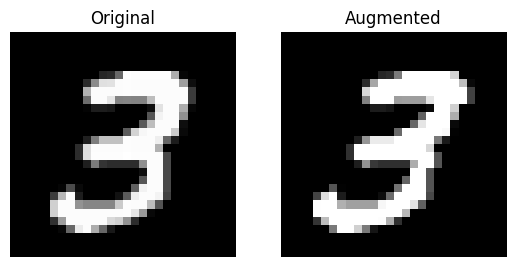

In [ ]:
num_to_view = 3 #Can change

for index, (image, label) in enumerate(train_dataset):
    if (label == num_to_view):
        break

norm_image = get_image(norm_dataset, index)
aug_image = get_image(aug_dataset, index)

side_by_side_plot(norm_image, aug_image, "Original", "Augmented")

## __Model Evaluation and Selection__

### __Visualizing Loss and Validation Accuracy Convergence__

In [ ]:
def plot_info(epoch, losses, vals = None):
    epochs = list(range(1, epoch + 2))
    plt.figure(figsize=(6, 3))

    plt.plot(epochs, losses)
    if vals:
        plt.plot(epochs, vals)
        plt.legend(['Average Loss', 'Validation Accuracy'])

        #return highest validation accuracy and the epoch it was in (index + 1)
        max_val_acc = max(vals)
        max_val_epoch = vals.index(max_val_acc) + 1 
        
        # Annotate the maximum validation accuracy on the plot
        plt.annotate(f'Max at Epoch {max_val_epoch}: {max_val_acc:.2f}', 
                     xy=(max_val_epoch, max_val_acc), 
                     xytext=(max_val_epoch, max_val_acc + 0.05),
                     arrowprops={'facecolor': 'black', 'shrink': 0.20})
    else:
        plt.legend(['Average Loss'])
    plt.show()

### __Training and Evaluation Methods__

In [ ]:
def evaluate(model, loader):
    model.eval()

    #Counters
    correct = 0
    total = 0

    #empty tensor of datatype long
    all_predicted = torch.tensor([], dtype=torch.long).to(device)


    '''with - gradient descent will be tracked outside of with block. Not tracking ->
    doesn't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
    Saves memory and its faster'''
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device, non_blocking = True), labels.to(device, non_blocking = True) 

            outputs = model(images) #self.forward(images), uses __call__
            '''Return two tensors in tuple for max values (brightest neurons) and their indices per training 
            example in mini batch. Convention to store unimportant stuff in _. 1 as parameter input means 
            find max along dimension 1. Outputs = (batch_size, num_classes). Max outputs the max output neuron
            and index (number) per batch.
            '''
            _, predicted = torch.max(outputs, 1) #tensor

            #add this tensor for predicted numbers to the list; cat concatenates two tensors
            all_predicted = torch.cat((all_predicted, predicted), dim = 0) 

            #Update Counters
            total += labels.size(0) #size of first dimension (each minibatch)

            #Compare each tensor, which returns new tensor with each component being True or False
            #Sum amount of True in the tensor
            correct += (predicted == labels).sum().item()

    accuracy = (correct/total) * 100
    torch.mps.synchronize() if device == torch.device('mps') else None
    
    return accuracy, all_predicted

In [ ]:
def train_model(model, train_loader, optimizer, loss_f, num_epochs, val_loader = None, visualize = False):
    model.train() #prevents weird stuff (e.g. optimizer being weird)
    average_losses = []
    val_accuracies = []
    
    for epoch in range(num_epochs):
        tot_epoch_loss = 0
        processed_batches = 0

        for images, labels in train_loader: 
            '''__getitem__ of dataset is called to transform each element; increasing numworkers decreases time of transformed images, labels being assigned in first line.'''
            images, labels = images.to(device, non_blocking = True), labels.to(device, non_blocking = True) 

            '''Each parameter has its own tensor with its partial derivative in .grad attribute of tensor; step() accesses these. Zero grad ensures recalculation of partials in backprop.'''
            optimizer.zero_grad()

            outputs = model(images) #passes this to forward

            target = F.one_hot(labels, num_classes=10).float() 

            loss = loss_f(outputs, target) #tensor with scalar and computation graph
            loss.backward() #backward propogation to compute gradient

            optimizer.step() #updates model parameters (takes "step")
            
            tot_epoch_loss += loss.item()
            processed_batches +=1

            #Colab
            #xm.optimizer_step(optimizer) #ensures gradient calculated first
            #xm.mark_step()

        avg_loss = tot_epoch_loss/processed_batches
        average_losses.append(avg_loss)

        torch.mps.synchronize() if device == torch.device('mps') else None
        
        #Append validation accuracy values for k-folds plot
        if visualize and val_loader:
                val_accuracy, __ = evaluate(model, val_loader)
                val_accuracies.append(val_accuracy)

        #Printing format for k-folds and regular training
        if (epoch == 0 or epoch == num_epochs - 1):
            if val_loader: 
                train_accuracy, __ = evaluate(model, train_loader)
                val_accuracy, __ = evaluate(model, val_loader)
                print(f'Epoch {epoch + 1} -- Average Loss:{avg_loss: .4f}, Training Accuracy:{train_accuracy : .2f}%, Validation Accuracy:{val_accuracy : .2f}%')
            else:
                print(f'Epoch {epoch + 1} -- Average Loss:{avg_loss: .4f}')
    print("")
    
    if visualize: 
        plot_info(epoch, average_losses, val_accuracies if val_loader else None)
    return val_accuracy if val_loader else None #last val accuracy

### __Altering Hyperparameters for Grid Search__

In [ ]:
def alter_hyper(hypers, hypercombo):
    hypers.l_rate = hypercombo['l_rate']
    hypers.b_size = hypercombo['b_size']
    hypers.epochs = hypercombo['epochs']
    hypers.drop_rate = hypercombo['drop_rate']
    hypers.hidden_one = hypercombo['hidden_one']
    hypers.hidden_two = hypercombo['hidden_two']
    hypers.n_slope = hypercombo['n_slope']
    hypers.augment = hypercombo['augment']
    hypers.prob_augment = hypercombo['prob_augment']
    hypers.beta_one = hypercombo['beta_one']
    hypers.beta_two = hypercombo['beta_two']
    hypers.beta_two = hypercombo['beta_two']
    hypers.degrees = hypercombo['degrees']
    hypers.trans_horz = hypercombo['trans_horz']
    hypers.trans_vert = hypercombo['trans_vert']
    hypers.scale_min = hypercombo['scale_min']
    hypers.scale_max = hypercombo['scale_max']
    hypers.shear = hypercombo['shear']
    hypers.brightness = hypercombo['brightness']
    hypers.contrast = hypercombo['contrast']

### __K-folds Cross Validation - Approach 1 (Splitting Training)__

#### __Approach 1 - Directly Splitting Training Subset into Augmented and Normal__

In [ ]:
FOLDS = 10

In [ ]:
def scripted_or_not(model, hypers):
    if hypers.drop_rate == 0:
       scripted_model = jit.script(model)
       return scripted_model.to(device)
    else:
        return model

In [ ]:
#already ensure validation only used once per sample
def k_folds(train_dataset, hypers, visualize = False):

    kf = KFold(n_splits = FOLDS, shuffle = True, random_state = 20)
    validation_accuracies = []

    cross_entropy = nn.CrossEntropyLoss()

    for fold, (train_indices, val_indices) in enumerate(kf.split(train_dataset)):
        print(f'Fold {fold + 1}')

        #My actual validation
        val_transformed = create_dataset_t(train_dataset, val_indices, transform_norm)
        val_loader = DataLoader(val_transformed, batch_size = 512, shuffle=False, pin_memory=True, num_workers=2)

        train_subset = Subset(train_dataset, train_indices)
        train_loader = norm_aug_loader_one(train_subset, hypers)
        
        model = MLP(hypers).to(device) #ensures parameters reset and each fold is independent
        actual_model = scripted_or_not(model, hypers)
        adam = optim.Adam(actual_model.parameters(), lr = hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08) #forget info from EWMA
        
        last_epoch_val_accuracy = train_model(actual_model, train_loader, optimizer = adam, loss_f = cross_entropy, 
                                              num_epochs = hypers.epochs, val_loader = val_loader, visualize = visualize)

        validation_accuracies.append(last_epoch_val_accuracy)

    mean_val_accuracy = np.mean(validation_accuracies)
    #Use average validation accuracy across all folds to evaluate model
    return mean_val_accuracy


In [ ]:
mean_val_accuracy = k_folds(train_dataset, hypers, visualize = True)
print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')

#### __Approach 2 - Mapping Some Original Training Indices from Training Subset to Separate Augmented Dataset__

In [ ]:
def _calc_alt_indices(norm_dataset, norm_train_indices, hypers, k_folds):
    '''This numberr maximizes amount of data for 70 30 prop; total_dataset_length*prob_normal.7 = len_normal; solve for total example length
    . This allows for 60_000 (70%) has normal transformation. Without +1 would be 59999'''
    total_training_examples = int((len(norm_dataset)/ (1-hypers.prob_augment)) + 1)

    #if k_folds take less data to maintain 70 30 prop
    len_val = len(norm_dataset)/FOLDS if k_folds else 0 #amount in validation set with k folds
    training_num = (len(norm_dataset) - len_val) if k_folds else total_training_examples

    num_norm_train_indices = int(training_num * (1-hypers.prob_augment))
    num_aug_train_indices = int(training_num * hypers.prob_augment)

    mapped_indices = norm_train_indices + len(norm_dataset) #maps indices to aug
    
    norm_train_indices = np.random.choice(norm_train_indices, num_norm_train_indices, replace = False) 
    norm_train_indices = norm_train_indices.reshape(-1) #should be 1D already
    aug_train_indices = np.random.choice(mapped_indices, num_aug_train_indices, replace = False)  
    
    return np.concatenate([norm_train_indices, aug_train_indices])

def norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers, k_folds = False):
    full_train_indices = _calc_alt_indices(norm_dataset, norm_train_indices, hypers, k_folds)
    train_subset = Subset(full_train_dataset, full_train_indices)

    #Shuffles batch order + samples within batches per epoch
    if k_folds:
        return DataLoader(train_subset, batch_size = hypers.b_size, shuffle=True, pin_memory=True, num_workers=8, prefetch_factor=8, persistent_workers=True)
    else:
        return DataLoader(train_subset, batch_size = hypers.b_size, shuffle=True, pin_memory=True, num_workers=14, prefetch_factor=4, persistent_workers=True)
    

In [ ]:
#random_state like seed; generates train/validation indices per fold
def k_folds_two(norm_dataset, hypers, visualize = False):
    
    kf = KFold(n_splits = FOLDS, shuffle=True, random_state=20)
    validation_accuracies = []
    
    '''by default split only works with indices arrays unless it can use length attribute of dataset, which Pytorch provides.
    This works too: norm_dataset.__len__(), dunder methods simplify syntax'''
    all_norm_indices = np.arange(len(norm_dataset))

    cross_entropy = nn.CrossEntropyLoss()

    #Define aug_transformation based on hyperparameters -> create aug_dataset -> create full training dataset
    __, transform_aug = transformations(hypers)
    aug_dataset = replace_victim_with_incoming_aug(REPLACE_LIST, transformation=transform_aug)
        
    full_train_dataset = ConcatDataset([norm_dataset, aug_dataset])

    for fold, (norm_train_indices, val_indices) in enumerate(kf.split(all_norm_indices)):
        print(f'Fold {fold + 1}')

        #Create validation and training sets
        val_subset = Subset(norm_dataset, val_indices) #Since we put in norm don't need to transform validation
        val_loader = DataLoader(val_subset, batch_size=512, shuffle=False, pin_memory=True, num_workers=2)
        train_loader = norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers, k_folds = True)
        
        #instantiate model and optimizer
        model = MLP(hypers).to(device) #ensures parameters reset and each fold is independent
        actual_model = scripted_or_not(model, hypers)
        
        adam = optim.Adam(actual_model.parameters(), lr = hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08) #forget info from EWMA
        last_epoch_val_accuracy = train_model(actual_model, train_loader, optimizer = adam, loss_f = cross_entropy, 
                                              num_epochs = hypers.epochs, val_loader = val_loader, visualize=visualize)
        
        validation_accuracies.append(last_epoch_val_accuracy)

    return np.mean(validation_accuracies)


In [ ]:
mean_val_accuracy = k_folds_two(norm_dataset, hypers, visualize=True)
print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')

### __Hyperparameter Tuning with Gridsearch__

In [ ]:
#All other hyperparameters previously tested
#Dictionary for all values I want to test for the gridsearch
hyperdict = {
    'l_rate': [hypers.l_rate],
    'b_size': [hypers.b_size],
    'epochs': [hypers.epochs],
    'drop_rate': [hypers.drop_rate],
    'hidden_one': [hypers.hidden_one],
    'hidden_two': [hypers.hidden_two],
    'n_slope': [hypers.n_slope],
    'augment': [hypers.augment],
    'prob_augment': [hypers.prob_augment],
    'beta_one': [hypers.beta_one],
    'beta_two': [hypers.beta_two],
    "degrees": [hypers.degrees, 20],
    "trans_horz": [hypers.trans_horz],
    "trans_vert": [hypers.trans_vert],
    "scale_min": [hypers.scale_min],
    "scale_max": [hypers.scale_max],
    "shear": [hypers.scale_max],
    "brightness": [hypers.brightness],
    "contrast": [hypers.contrast]
}

print(len(ParameterGrid(hyperdict)))
    

2


In [ ]:
def grid_search(norm_dataset, hypers, hyperdict):
    best_hypers = None
    best_mean_val_accuracy = 0
    orig_hypers = hypers #store original hypers to reset after grid search finishes
    
    for hypercombo in ParameterGrid(hyperdict): 
        print(hypercombo)
        alter_hyper(hypers, hypercombo)

        mean_val_accuracy = k_folds_two(norm_dataset, hypers, hypercombo, grid_search=True)
        print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%\033[0m\n')
        
        if (mean_val_accuracy > best_mean_val_accuracy):
            best_mean_val_accuracy = mean_val_accuracy
            best_hypers = hypercombo
    
    hypers = orig_hypers
    return best_hypers, best_mean_val_accuracy

In [ ]:
best_hypers, best_mean_val_accuracy = grid_search(norm_dataset, hypers, hyperdict) #full dataset made in kfolds to ensure proper proportions
print(f'\n\033[1mBest Hyperparameters: {best_hypers}\nBest Mean Validation Accuracy:{best_mean_val_accuracy: .2f}%\033[0m')
#.45 dropout gives 98.6 validation but lower test accuracy; go with 0 dropout

## __Training the Model__ 

### __Preparing the Data__

In [ ]:
#Approach 1
norm_aug_loader_one = norm_aug_loader_one(train_dataset, hypers)

In [ ]:
#Approach 2
full_train_dataset = ConcatDataset([norm_dataset, aug_dataset])

norm_train_indices = np.arange(len(norm_dataset))
norm_aug_loader = norm_aug_loader_two(full_train_dataset, norm_dataset, norm_train_indices, hypers)

### __Warming Up the DataLoader__

In [ ]:
def benchmark_warm_loader(loader):
    start_time = time.time()
    for i, data in enumerate(loader):
        if i == 100: 
            break
    print(f"Time to load and preprocess 100 batches: {time.time() - start_time}")

In [ ]:
benchmark_warm_loader(norm_aug_loader) #also initializes the workers

Time to load and preprocess 100 batches: 0.3558521270751953


### __Benchmarking JIT__

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
model = MLP(hypers).to(device)
adam = optim.Adam(model.parameters(), lr = hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08)


start_time = time.time()
train_model(model = model, train_loader = norm_aug_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs)
print(f"Time to train non-scripted model with pinned memory and asynchronous data transfer: {time.time() - start_time}")

In [ ]:
scripted_model = jit.script(model)
scripted_model = scripted_model.to(device)
adam = optim.Adam(scripted_model.parameters(), lr = hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08)

start_time = time.time()
train_model(model = scripted_model, train_loader = norm_aug_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs)
print(f"Time to train scripted model with pinned memory and asynchronous data transfer: {time.time() - start_time}")

### __Finding the Best Model Given the Hyperparameters__

In [ ]:
def train_keep_best_model(hypers, train_loader, test_loader, num_trials):
    best_model = None
    best_accuracy = 0
    cross_entropy = nn.CrossEntropyLoss()

    for i in range(0, num_trials):
        model = MLP(hypers).to(device)
        actual_model = scripted_or_not(model, hypers)
        adam = optim.Adam(actual_model.parameters(), hypers.l_rate, betas=(hypers.beta_one, hypers.beta_two), eps=1e-08) 
        train_model(model = actual_model, train_loader = train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = hypers.epochs)
        
        accuracy, __ = evaluate(model, test_loader)
        print(f'Test Accuracy:{accuracy: .2f}%\n')

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
    
    return best_model, best_accuracy

In [ ]:
model, best_test_acc = train_keep_best_model(hypers, norm_aug_loader, test_loader, 100)
print(f'\n\033[1mBest Test Accuracy:{best_test_acc: .2f}%\033[0m')
#36 MIN FOR 20 MODELS; 18 with JIT
#43 seconds 20 epochs with resetting parameters instead of instantiating

## __Saving the Model__

In [ ]:
#most data - approach 1 for splitting aug/normal; least is approach 2 because its among 60000
model_name = f'mlp-h1-{hypers.hidden_one}-{hypers.prob_augment}aug2-altdistrib-{best_test_acc:.2f}.pth'
print(model_name)

mlp-h1-1024-0.3aug2-altdistrib-98.93.pth


### __Local__

In [ ]:
torch.save(model.state_dict(), f'../models/{model_name}')

### __Colab__

In [ ]:
#files.download(f'{model_name}.pth')
model_downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", f'{model_name}.pth')

model_destination_path = f'~/Documents/deep-learning-mnist/models/{model_name}.pth'

shutil.move(model_downloads_path, model_destination_path)

## __Loading the Saved Model__

In [ ]:
def load_model(path_to_dict, hypers):
    # Instantiate the model
    model = MLP(hypers).to(device)
    #Update model's parameters to what it was after training
    #model.load_state_dict(torch.load(f'../models/{trained_model}.pth'))
    model.load_state_dict(torch.load(path_to_dict, map_location = device))
    
    '''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing you want all neurons in model to be used, 
    so eval fixes this as well as other settings for testing so model acts "normally"'''
    actual_model = scripted_or_not(model, hypers)
    actual_model.eval()

    return actual_model

In [ ]:
model = load_model('../models/mlp-73ep-h11024-0.3aug2-altdistrib-99.02.pth', hypers)

## __Final Model Testing and Analysis__

### __Testing Accuracy__

In [ ]:
'''Random augmentations/computer floating point computation rounding/parallel computations can lead to slight variability in the accuracies'''
train_accuracy, __ = evaluate(model, loader = norm_aug_loader)
print(f'Train Accuracy:{train_accuracy : .2f}%') 

test_accuracy, predicted = evaluate(model, loader = test_loader)
print(f'Test Accuracy:{test_accuracy : .2f}%')

Train Accuracy: 99.37%
Test Accuracy: 99.02%


### __Summary Statistics__

#### __Recall Per Digit__

In [ ]:
recalls = {}

for i in range(0,10):
    one_digit_indices = digit_indices(dataset = test_dataset, digit = i)
    one_digit_test_set = Subset(test_dataset, one_digit_indices)
    one_digit_loader = DataLoader(one_digit_test_set, batch_size = 512, shuffle = False, pin_memory=True, num_workers = 2)

    recall, __ = evaluate(model, loader = one_digit_loader)
    recalls[i] = recall

sorted_recalls = sorted(recalls.items(), key = itemgetter(1), reverse = True)

for digit, recall in sorted_recalls:
    print(f'Recall for {digit}:{recall: .2f}%')

Recall for 0: 99.80%
Recall for 6: 99.48%
Recall for 4: 99.39%
Recall for 1: 99.30%
Recall for 8: 99.28%
Recall for 9: 99.11%
Recall for 3: 98.91%
Recall for 2: 98.84%
Recall for 7: 98.25%
Recall for 5: 97.76%


#### __Classification Report__

In [ ]:
'''Can't append lists otherwise you get nested list structure. Can either append each element to the list in loop or use extend().
Numpy array eventually required for creating the confusion matrix. Python lists memory works like ArrayLists while numpy arrays work
like normal arrays. Homogenous, contiguous np array means easier to calculate memory address of element so CPU can access stuff much faster 
for numpy. Unlike numpy, Python doesn't store objects themselves in list (fast) but instead a pointer to support heterogenous list. 
np array must be on CPU.'''

labels = []
for image, label in test_dataset:
    labels.append(label)

np_labels = np.array(labels)
np_predicted = predicted.to("cpu").numpy() #np arrays 

In [ ]:
'''Numbers often misclassified as 5 probably because there are less 5s in the dataset.'''
class_precisions = precision_score(np_labels, np_predicted, average='weighted')
class_recalls = recall_score(np_labels, np_predicted, average='weighted')
class_f1_scores = f1_score(np_labels, np_predicted, average='weighted')

print(f"Precision:{class_precisions: .4f}, Recall:{class_recalls: .4f}, F1 Score:{class_f1_scores: .4f}")

Precision: 0.9902, Recall: 0.9902, F1 Score: 0.9902


In [ ]:
report = classification_report(np_labels, np_predicted)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      1.00      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       1.00      0.98      0.99       892
           6       0.98      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### __Confusion Matrix__

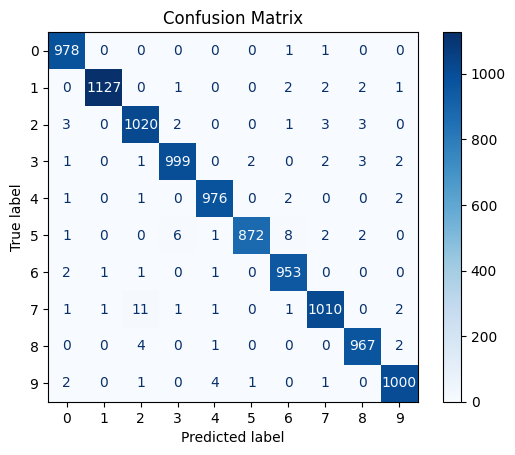

In [ ]:
cm = confusion_matrix(np_labels, np_predicted)

#matplotlib object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(0,10)])

disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

## __Inference on a New Image__

### __Pixelation and Preprocessing__

In [ ]:
def pixelate_image(image, pixelation_level):
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted (based on distance) average of 
    4 nearest pixels of where it would go to determine new value. Then split those big pixels up again 
    so the size is same as original but looks more pixelated.'''

    #open and greyscale image (compress to 1 channel)
    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def pixelate_preprocess(image, pixelation_level):
    image = pixelate_image(image, pixelation_level)
    image = transform_norm(image)  #images -> pixel values-> normalize
    image = image.unsqueeze(0)  #Add singleton dimension (batch_size) to image; not used, but specific shape necessary for model
    return image

In [ ]:
def preprocess(image):
    image = image.resize((28, 28))
    image = transform_norm(image) 
    image = image.unsqueeze(0)
    return image

### __Visualizing the Pixelated Image__

In [ ]:
image_path = '../data/test-images/9-4.png'
image = Image.open(image_path).convert('L')

pixelation_level = 1
pixelated_image = pixelate_image(image, pixelation_level)

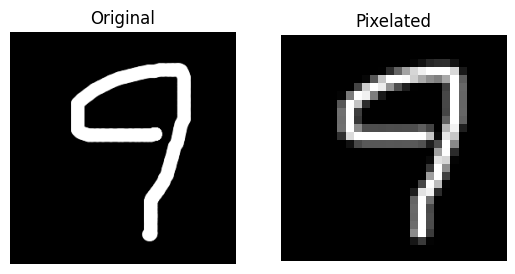

In [ ]:
side_by_side_plot(image, pixelated_image, "Original", "Pixelated")

In [ ]:
def classify_image(image):
    #image_transformed = pixelate_preprocess(image_path, pixelation_level).to(device)
    image_transformed = preprocess(image).to(device)

    with torch.no_grad():
        outputs = model(image_transformed)
        _, prediction = torch.max(outputs, dim = 1)

        probabilities = F.softmax(outputs, dim = 1) #probabilities[i] that contains softmax for outputs of i+1 image 

    #[(number, probability tensor)...]; enumerate packs into tuple with counter
    prob_classes = list(enumerate(probabilities[0])) 

    #to sort by max, extract probability with itemgetter
    prob_classes.sort(key = itemgetter(1), reverse = True)

    return prob_classes, prediction

In [ ]:
prob_classes, prediction = classify_image(image)

for num, probability in prob_classes:
    print(f'Probability of {num}:{probability.item() * 100: .3f}%')

print(f'\nPredicted Number: {prediction.item()}')

Probability of 9: 72.717%
Probability of 7: 23.322%
Probability of 3: 3.504%
Probability of 8: 0.303%
Probability of 2: 0.127%
Probability of 4: 0.014%
Probability of 5: 0.013%
Probability of 1: 0.000%
Probability of 0: 0.000%
Probability of 6: 0.000%

Predicted Number: 9
